In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import autokeras as ak
import os
import tensorflow as tf
import time

In [2]:
data = np.load('/work/n1000000_0804_all_flat.npz')
cut_index = np.load('/work/NIO_largerthan1000_index.npy')

In [3]:
input_state = 2
target = data['theta23']
if input_state == 0:
    data_all = data['ve_dune']
elif input_state == 1:
    data_all = np.column_stack([data['ve_dune'], data['vu_dune'], data['vebar_dune'], data['vubar_dune']])
elif input_state == 2:
    data_all = np.column_stack([data['ve_dune'], data['vu_dune'], data['vebar_dune'], data['vubar_dune'], data['ve_t2hk'], data['vu_t2hk'], data['vebar_t2hk'], data['vubar_t2hk']])

x_train = data_all[:10000, cut_index]
y_train = target[:10000]
x_train2 = data_all[10000:900000, cut_index]
y_train2 = target[10000:900000]
x_test = data_all[900000:, cut_index]
y_test = target[900000:]

In [4]:
generate = 10
num_of_bins = len(x_train[0])
x_train_gen = np.reshape(np.random.normal(x_train, np.sqrt(x_train), size = (generate, len(x_train), num_of_bins)), (generate*len(x_train), num_of_bins))
y_train_gen = np.repeat(y_train, generate)
x_train2_gen = np.reshape(np.random.normal(x_train2, np.sqrt(x_train2), size = (generate, len(x_train2), num_of_bins)), (generate*len(x_train2), num_of_bins))
y_train2_gen = np.repeat(y_train2, generate)
x_test_gen = np.reshape(np.random.normal(x_test, np.sqrt(x_test), size = (generate, len(x_test), num_of_bins)), (generate*len(x_test), num_of_bins))
y_test_gen = np.repeat(y_test, generate)

In [5]:
clf = ak.StructuredDataRegressor(overwrite=True, max_trials=50)
clf.fit(x_train_gen, y_train_gen,
           validation_split = 0.1,
           batch_size=64,
           epochs=20,
           verbose=1,
           shuffle = True
       )

Trial 50 Complete [00h 01m 13s]
val_loss: 13.22744369506836

Best val_loss So Far: 13.13758659362793
Total elapsed time: 01h 12m 57s
INFO:tensorflow:Oracle triggered exit

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1/20
1563/1563 [==============================] - 4s 3ms/step - loss: 1039.6084 - mean_squared_error: 1039.6084
Epoch 2/20
1563/1563 [==============================] - 4s 3ms/step - loss: 43.1379 - mean_squared_error: 43.1379
Epoch 3/20
1563/1563 [==============================] - 4s 3ms/step - loss: 15.8143 - mean_squared_error:

In [6]:
model = clf.export_model()
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 17)]              0         
_________________________________________________________________
multi_category_encoding (Mul (None, 17)                0         
_________________________________________________________________
normalization (Normalization (None, 17)                35        
_________________________________________________________________
dense (Dense)                (None, 32)                576       
_________________________________________________________________
re_lu (ReLU)                 (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 16)               

In [7]:
model.fit(x_train2_gen, y_train2_gen,
           validation_split = 0.1,
           batch_size=64,
           epochs=20,
           verbose=1,
           shuffle = True
         )

Epoch 1/20
125157/125157 [==============================] - 285s 2ms/step - loss: 12.4302 - mean_squared_error: 12.4302 - val_loss: 12.3887 - val_mean_squared_error: 12.3887
Epoch 2/20
125157/125157 [==============================] - 285s 2ms/step - loss: 12.4046 - mean_squared_error: 12.4046 - val_loss: 12.3887 - val_mean_squared_error: 12.3887
Epoch 3/20
125157/125157 [==============================] - 286s 2ms/step - loss: 12.4047 - mean_squared_error: 12.4047 - val_loss: 12.3887 - val_mean_squared_error: 12.3887
Epoch 4/20
125157/125157 [==============================] - 285s 2ms/step - loss: 12.4046 - mean_squared_error: 12.4046 - val_loss: 12.3887 - val_mean_squared_error: 12.3887
Epoch 5/20
125157/125157 [==============================] - 283s 2ms/step - loss: 12.4047 - mean_squared_error: 12.4047 - val_loss: 12.3887 - val_mean_squared_error: 12.3887
Epoch 6/20
125157/125157 [==============================] - 282s 2ms/step - loss: 12.4047 - mean_squared_error: 12.4047 - val_loss

In [8]:
model.evaluate(x_test_gen, y_test_gen)
pre_test = model.predict(x_test_gen)

31250/31250 [==============================] - 58s 2ms/step - loss: 12.4261 - mean_squared_error: 12.4261


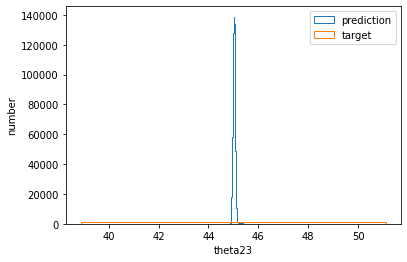

In [9]:
plt.hist(pre_test, histtype = 'step', bins = 100, label = 'prediction')
plt.hist(y_test, histtype = 'step', bins = 100, label = 'target')
plt.xlabel('theta23')
plt.ylabel('number')
plt.legend()
plt.show()

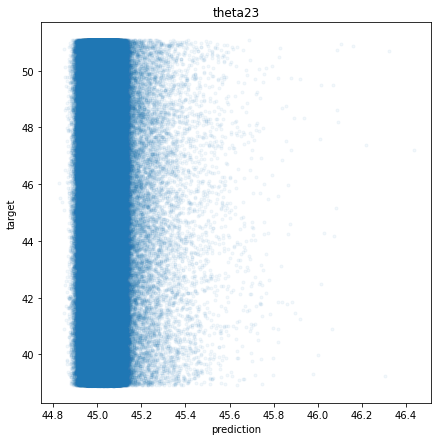

In [10]:
plt.figure(figsize=(7,7))
plt.plot(pre_test[:,0], y_test_gen, '.', alpha = 0.05)
plt.xlabel('prediction')
plt.ylabel('target')
plt.title('theta23')
plt.show()

In [11]:
if input_state == 0:
    modelname = '/work/Regression/models_ve_dune/0803_theta23_1.h5'
    if not os.path.isfile(modelname):
        model.save(modelname)
elif input_state == 1:
    modelname = '/work/Regression/models_all_dune/0803_theta23_1.h5'
    if not os.path.isfile(modelname):
        model.save(modelname)
elif input_state == 2:
    modelname = '/work/ML4NO/ML/Regression/perturb_cut/0804_cut1000_theta23_1.h5'
    if not os.path.isfile(modelname):
        model.save(modelname)